In [1]:
#updated 2025-07-24 11:58
from heat_pump_model import *
from libraries import * 
from refrigerant_properties import *
import numpy as np
import matplotlib.pyplot as plt
from utilities.unit_defs import Q_


In [2]:
#process energy rate csv into 8760 energy cost
df = pd.read_csv("utilities/Seattle_City_Light_Medium_Business_energy.csv")
rate_kwh = Q_(df["energy_rate"].values, "USD / kWh")
#assign the csv with the demand charges
demand_charge_filepath="utilities/Seattle_City_Light_Medium_Business_demand.csv"
#assign the csv with the load profile
df2 = pd.read_csv("Thermal Loadshapes/brew_262kW_2h_2025_hourly.csv")
load_profile= Q_(df2["load_kW"].values, "kW")
#assign the csv with the gas prices
gas_prices = pd.read_csv("utilities/2025-07-24 - NR - Industrial Gas Rates.csv")
gas_location = "Seattle" #SoCal,Seattle, Hawaii, Olympic Peninsula

Calculate COP Called
Average Theoretical COP: 3.79
Average Estimated COP: 2.65
Calculate Heat Pump Costs
Max weekly moving average: 28.07 kW during week 27
Largest storage requirement: 1796.57 kWh over 104 hours
System Power: 36.49 kW
System Storage: 2,335.54 kWh
Storage Volume: 43,284.84 l
Storage Pressure: 618.23 kPa
Heat Pump Cost: 14,597.14 $
Storage Cost: 28,568.00 $
Steam Dischage Cost: 9,432.00 $
Total Capital Cost: 52,597.14 $
Capacity Factor: 0.055
One Year Fixed O&M Costs: 1,459.71 $/yr
One Year Generation & Transmission Costs: 4,593.63 $
Demand Charges with Storage:  388.95 $
One Year Total Energy Costs: 4,982.58 $/yr
One Year Total Operating Costs: 6,442.29 $/yr
Annual Heat Output: 429.11 MMBtu
LCOH: 24.85 $/MMBtu
Levelized Capex: 9.84 $/MMBtu
Levelized OpEx: 15.01 $/MMBtu

COMPARE TO NO STORAGE
No Storage LCOH: 69.37 $/MMBtu
Levelized Capex no storage: 19.60 $/MMBtu
Levelized OpEx no storage: 49.77 $/MMBtu
Writing all output to a file


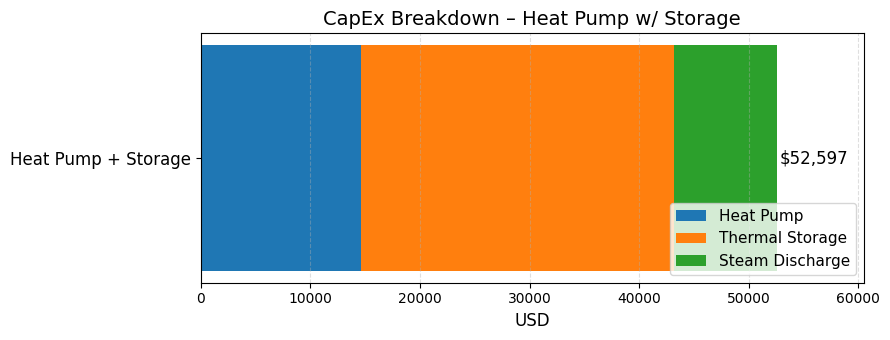

(<Figure size 900x350 with 1 Axes>,
 <Axes: title={'center': 'CapEx Breakdown – Heat Pump w/ Storage'}, xlabel='USD'>)

In [3]:
hp_test = heat_pump()
hp_test.construct_yaml_input_quantities('heat_pump_model_inputs.yml')
hp_test.hot_temperature_desired = Q_(np.array([120]*8760), 'degC')
hp_test.hot_temperature_minimum = Q_(np.array([95]*8760), 'degC')

#variable electicity rates with demand charges
hp_test.hourly_utility_rate = rate_kwh
hp_test.demand_charge_file=demand_charge_filepath
hp_test.process_heat_requirement=load_profile

hp_test.run_all('hp_test')
hp_test.plot_capex_breakdown()

In [4]:
from gas_model import *
gas_test = gas_heater()
gas_test.construct_yaml_input_quantities('gas_model_inputs.yml')
gas_test.hot_temperature = Q_(np.array([120]*8760), 'degC')
gas_test.cold_temperature = Q_(np.array([95]*8760), 'degC') #in the gas case 'cold temp' is the return to the boiler
gas_test.process_heat_requirement=load_profile
gas_test.gas_price = Q_(gas_prices.loc[gas_prices['Location'] == gas_location, 'Rate [$/mmbtu]'].iloc[0], 'USD/MMBtu')

gas_test.run_all('gas_test')


Capital Cost: 8,045.83 $
Heat Delivered: 429.11 MMBtu
Fuel Consumed: 536.39 MMBtu
Capacity Factor: 0.055
One Year Fixed O&M Costs: 44.70 $/yr
One Year Variable O&M Costs: 4.29 $/yr
One Year Energy Costs: 7,670.36 $/yr
One Year Operating Costs: 7,719.35 $/yr
Overall LCOH: 19.49 $/MMBtu
Levelized Capex: 1.50 $/MMBtu
Levelized Opex: 17.99 $/MMBtu
Year 1 Emissions: 28.43 ton/yr
Writing all output to a file


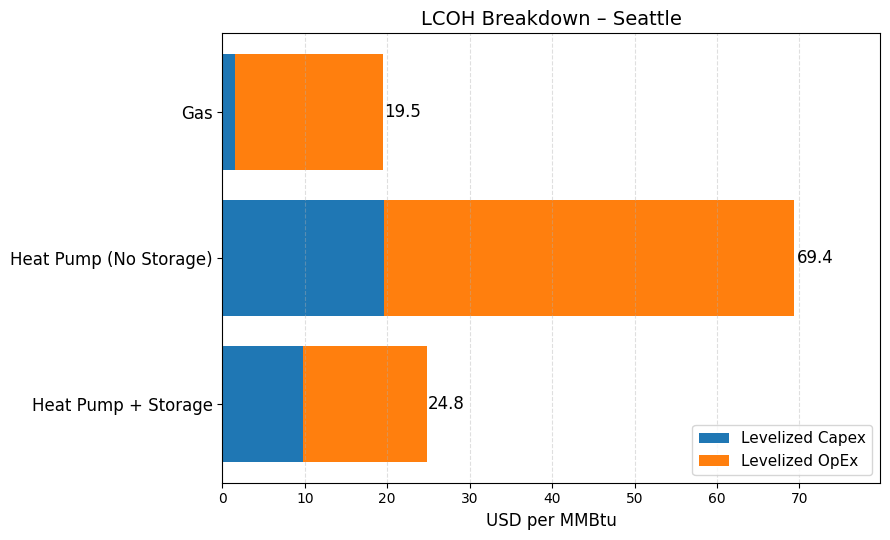

(<Figure size 900x550 with 1 Axes>,
 <Axes: title={'center': 'LCOH Breakdown – Seattle'}, xlabel='USD per MMBtu'>)

In [5]:
from plot_lcoh import plot_lcoh_breakdown

plot_lcoh_breakdown(hp_test, gas_test, gas_location)


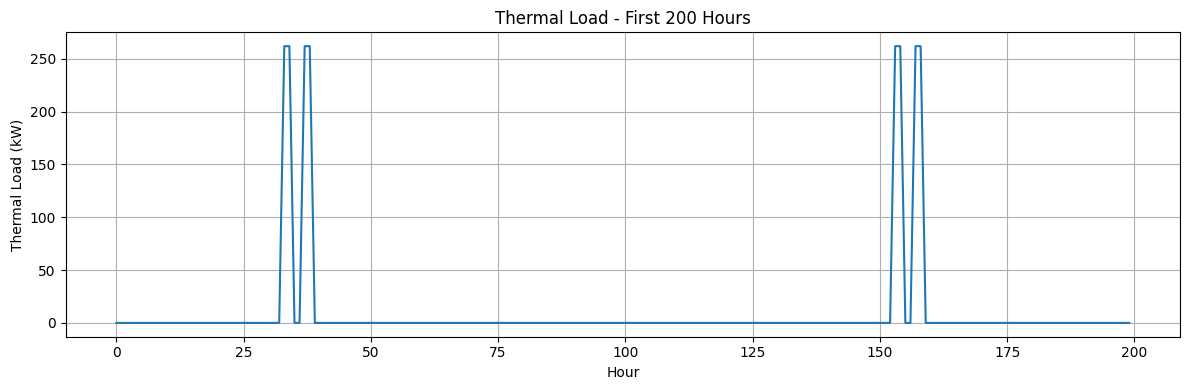

In [6]:
# Plot the first 200 hours of thermal load
plt.figure(figsize=(12, 4))
plt.plot(hp_test.process_heat_requirement[:200].magnitude)
plt.title("Thermal Load - First 200 Hours")
plt.xlabel("Hour")
plt.ylabel(f"Thermal Load ({hp_test.process_heat_requirement.units:~})")
plt.grid(True)
plt.tight_layout()
plt.show()

New Gas Payback: 59.60 yr
Existing Gas Payback: 65.90 yr
Tax Credit: 105,099.43 $
New Gas Payback With Tax Credit: -22.70 yr
Existing Gas Payback With Tax Credit: -16.40 yr
Heat Pump Price With Tax Credit: -20,944.01 $
Gross Margin: 60 percent


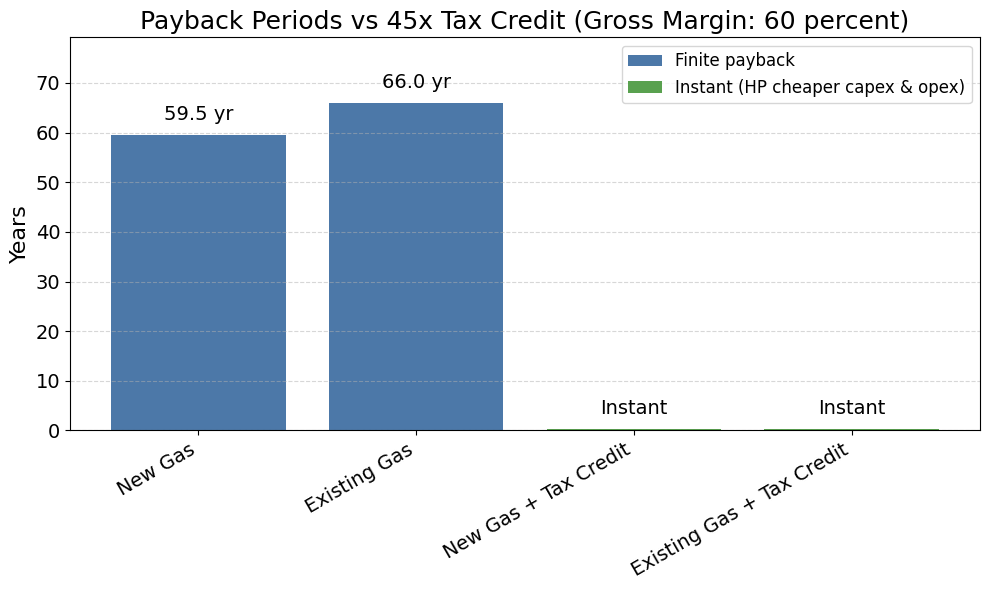

In [7]:
#Output Payback Periods
gross_margin = 0.6
hp_price = hp_test.total_capital*(1+gross_margin)

new_gas_payback=(hp_price-gas_test.capital_cost)/(gas_test.year_one_operating_costs-hp_test.year_one_operating_costs)
existing_gas_payback=(hp_price)/(gas_test.year_one_operating_costs-hp_test.year_one_operating_costs)
print('New Gas Payback: {:,~.2fP}'.format(new_gas_payback))
print('Existing Gas Payback: {:,~.2fP}'.format(existing_gas_payback))


#with the tax credit
tax_credit = (Q_(45, 'USD/kWh') * hp_test.storage_size.to('kWh')).to('USD')
print('Tax Credit: {:,~.2fP}'.format(tax_credit))
hp_price_tc = hp_test.total_capital*(1+gross_margin)-tax_credit

new_gas_payback_tax_cdt=(hp_price_tc-gas_test.capital_cost)/(gas_test.year_one_operating_costs-hp_test.year_one_operating_costs)
existing_gas_payback_tax_cdt=(hp_price_tc)/(gas_test.year_one_operating_costs-hp_test.year_one_operating_costs)
print('New Gas Payback With Tax Credit: {:,~.2fP}'.format(new_gas_payback_tax_cdt))
print('Existing Gas Payback With Tax Credit: {:,~.2fP}'.format(existing_gas_payback_tax_cdt))
print('Heat Pump Price With Tax Credit: {:,~.2fP}'.format(hp_price_tc))

#recalculate to check gross margin
hp_revenue=hp_price_tc+tax_credit
hp_margin = (hp_revenue / hp_test.total_capital-1) * Q_(100, 'percent')
print(f"Gross Margin: {hp_margin:.0fP}")

#plot payback periods
from payback_plot import plot_paybacks

_ = plot_paybacks(hp_price, hp_price_tc, hp_margin, gas_test, hp_test)